In [ ]:
!pip install python-louvain

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import unicodedata
import seaborn as sns
import community.community_louvain as community_louvain


# Carga y limpieza de datos

In [ ]:
df = pd.read_excel('/content/datosRed.xlsx')
df.head()

,AÑO,PERSONA,TIPO DE SERVICIO,NOMBRE DE LA TAREA,MODALIDAD,COMPLEJIDAD
0,2019,ID_1,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
1,2019,ID_2,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
2,2019,ID_3,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
3,2019,ID_4,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
4,2019,ID_5,SERV_1,TAREA_1.1,PRESENCIAL,BAJA


## Preprocesamiento de datos


In [ ]:
def _normalize_col(col):
    s = unicodedata.normalize('NFKD', str(col)).encode('ascii', 'ignore').decode()
    s = s.upper()
    s = re.sub(r'[^A-Z0-9]+', '_', s).strip('_')
    return s

In [ ]:
# Mapa de nombre normalizado -> nombre original
norm_map = { _normalize_col(c): c for c in df.columns }

# Renombrar variantes comunes a nombres canónicos sin tildes
final_rename = {}
for norm, orig in norm_map.items():
    if 'TIPO' in norm and 'SERVICIO' in norm:
        final_rename[orig] = 'TIPO_SERVICIO'
    elif 'NOMBRE' in norm and 'TAREA' in norm:
        final_rename[orig] = 'NOMBRE_TAREA'
    elif norm in ('ANO', 'ANIO', 'YEAR'):
        final_rename[orig] = 'ANO'
    elif 'PERSONA' in norm or 'CLIENTE' in norm or 'CLIENTES' in norm:
        final_rename[orig] = 'PERSONA'
    elif 'MODALIDAD' in norm:
        final_rename[orig] = 'MODALIDAD'
    elif 'COMPLEJIDAD' in norm:
        final_rename[orig] = 'COMPLEJIDAD'

if final_rename:
    df = df.rename(columns=final_rename)

In [ ]:
# Verificar que las columnas requeridas ahora existan
required = ['ANO', 'PERSONA', 'TIPO_SERVICIO', 'NOMBRE_TAREA', 'MODALIDAD', 'COMPLEJIDAD']
missing = [c for c in required if c not in df.columns]
if missing:
    print("Columnas faltantes después de la normalización:", missing)
    print("Columnas disponibles:", list(df.columns))
    raise KeyError(f"Faltan columnas requeridas: {missing}")

print(f"Datos cargados: {len(df)} registros")
print(f"Columnas: {list(df.columns)}")

Datos cargados: 10384 registros
Columnas: ['ANO', 'PERSONA', 'TIPO_SERVICIO', 'NOMBRE_TAREA', 'MODALIDAD', 'COMPLEJIDAD']


Datos nulos

<Axes: >

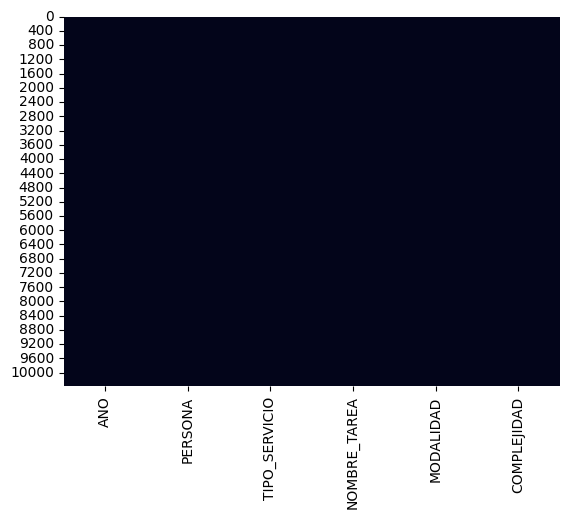

In [ ]:
sns.heatmap(df.isnull(), cbar=False)

No hay datos nulos, por lo que no se realiza ningún tratamiento


Datos duplicados

In [ ]:
df.duplicated().sum()

np.int64(2429)

In [ ]:
df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head(20)


,ANO,PERSONA,TIPO_SERVICIO,NOMBRE_TAREA,MODALIDAD,COMPLEJIDAD
0,2019,ID_1,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
59,2019,ID_1,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
9,2019,ID_10,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
135,2019,ID_10,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
169,2019,ID_156,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
272,2019,ID_156,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
15,2019,ID_16,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
65,2019,ID_16,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
200,2019,ID_187,SERV_1,TAREA_1.1,PRESENCIAL,BAJA
297,2019,ID_187,SERV_1,TAREA_1.1,PRESENCIAL,BAJA


Se eliminan los datos duplicados ya que no aportan ningún valor adicional al análisis.

In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [ ]:
# Información básica
n_clientes = df['PERSONA'].nunique()
n_servicios = df['TIPO_SERVICIO'].nunique()
n_tareas = df['NOMBRE_TAREA'].nunique()

print(f"\n Estadísticas generales:")
print(f"  - Clientes únicos: {n_clientes}")
print(f"  - Servicios únicos: {n_servicios}")
print(f"  - Tareas únicas: {n_tareas}")
print(f"  - Años: {sorted(df['ANO'].unique())}")


 Estadísticas generales:
  - Clientes únicos: 5090
  - Servicios únicos: 7
  - Tareas únicas: 18
  - Años: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


# Análisis EDA


Tendencia por año

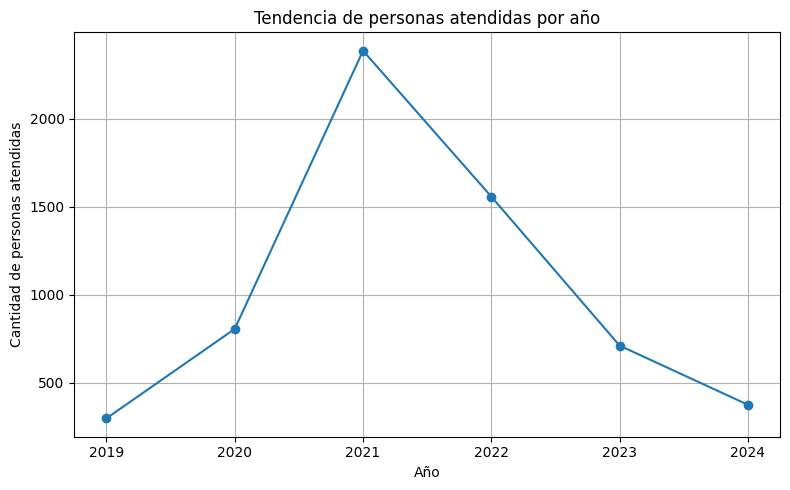

In [ ]:
personas_por_anio = df.groupby('ANO')['PERSONA'].nunique()

plt.figure(figsize=(8,5))
plt.plot(personas_por_anio.index, personas_por_anio.values, marker='o')
plt.xlabel("Año")
plt.ylabel("Cantidad de personas atendidas")
plt.title("Tendencia de personas atendidas por año")
plt.grid(True)
plt.tight_layout()
plt.show()


- El año con más actividad fue el 2021, el cual muestra un crecimiento abrupto en comparación a los años 2019 y 2020.
- A partir del año 2022, los registros disminuyeron constante y significativamente.
- Los registros en el año 2024 disminuyeron drásticamente, siendo el segundo año con menos registros.

Distribución por tipo de servicio

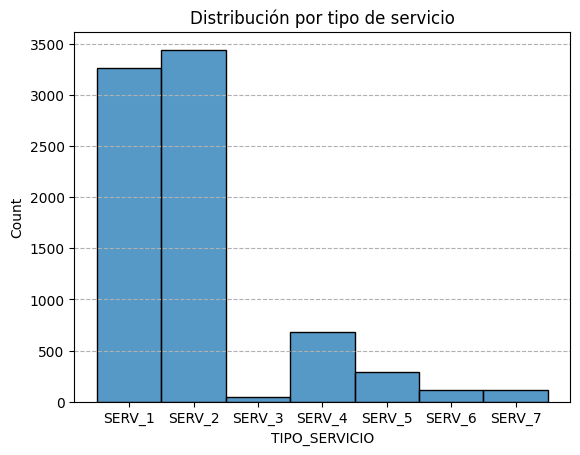

In [ ]:
sns.histplot(data=df, x='TIPO_SERVICIO', bins=20)
plt.title('Distribución por tipo de servicio')
plt.grid(axis='y', linestyle='--')
plt.show()

- La distribución por tipo de servicio se encuentra sesgada, la mayoría de registros se encuentran concentrados solo en dos tipos de servicio. El servicio con mayor concentración es el SERV_2 llegando casi a los 3500 de registros. El servicio SERV_1 es el segundo más frecuente, con cerca de 3,300 registros.
- Los demás servicios tinen menos de 1500 registros cada uno, siendo el SERV_4 el que cuenta con mayor concentración y el SERV_3 que tiene menos concentración, con menos de 50 registros.
- La alta concentración de datos en estos dos servicios indica que la mayoría de clientes en la red comparten al menos uno de ellos. Lo que contribuirá en que el clustering tenga un alto valor.


Distribución por tipo de tarea


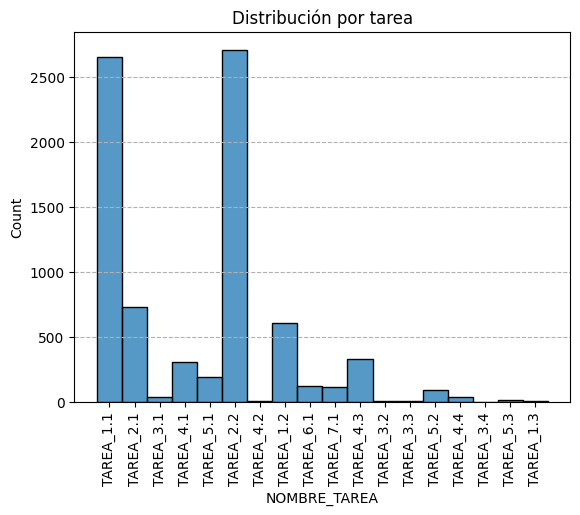

In [ ]:
sns.histplot(data=df, x='NOMBRE_TAREA', bins=20)
plt.title('Distribución por tarea')
plt.grid(axis='y', linestyle='--')
plt.xticks(rotation=90)
plt.show()

- Las tareas TAREA_1.1 y TAREA_2.2 concentran la mayor cantidad de registros superando por mucho a las demás. La tareas más frecuente es la TAREA_2.2 con casi 2700 registros. La segunda tarea más frecuente es la TAREA_1.1 con 2650 registros aproximadamente.
- Las tareas TAREA_2.1, TAREA_1.2, TAREA_4.3 y TAREA_4.1 con una concentración de registros dentro del rango de 300 a 700.
- El resto de tareas a penas tienn registros, algunas incluso con menos de 50 registros, esto nos indica que son tareas muy específicas u obsoletas.


Distribución por modalidad

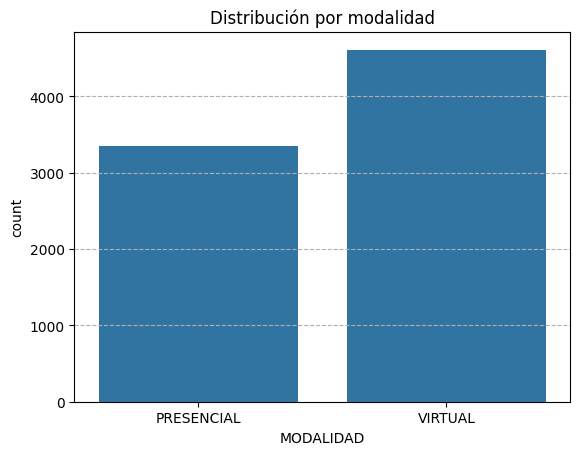

In [ ]:
sns.countplot(data=df, x='MODALIDAD')
plt.title('Distribución por modalidad')
plt.grid(axis='y', linestyle='--')
plt.show()

- La modalidad virtual es la que presenta mayor actividad entre las dos clases, contando con más de 4500 registros, mientras que la presencial cuenta con aproximadamente 3300 registros.
- Aunque la modalidad virtual sea la dominante, la modalidad presencial tiene una cantidad considerable de registros.
- El alto resultado en la categoría virtual podría deberse a que durante la etapa de la pandemia era la única modalidad disponible debido a las restricciones sanitarias.


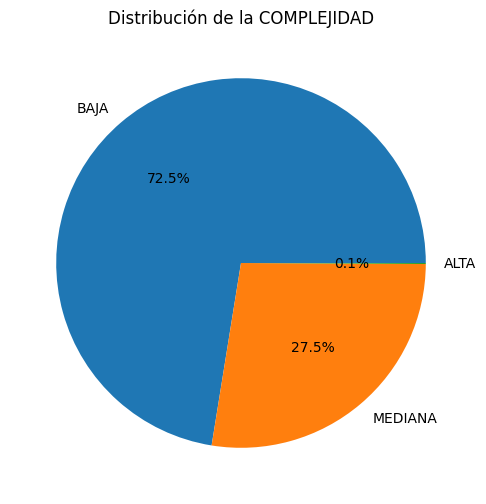

In [ ]:
counts = df['COMPLEJIDAD'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribución de la COMPLEJIDAD')
plt.show()


En el gráfico se ve un gran sesgo entre las categorías de complejidad. La complejidad baja es la que cuenta con mayor registros siendo el 72.5% de la actividad. A continuación, está la complejidad mediana con 27.5% de registros y finalmente la complejidad baja que no es significativa conformando tan solo el 0.1% de los registros.


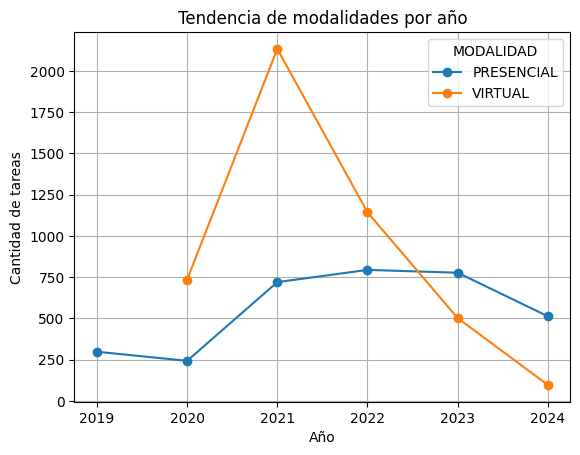

In [ ]:
df_mod = df.groupby(['ANO', 'MODALIDAD']).size().unstack()

df_mod.plot(marker='o')
plt.xlabel("Año")
plt.ylabel("Cantidad de tareas")
plt.title("Tendencia de modalidades por año")
plt.grid(True)
plt.show()


- Se puede ver que durante la época de pandemia, específicamente el primer año  (2020-2021), la modalidad virtual creció abruptamente y fue disminuyendo progresivamente hasta el 2024 donde se encuentra la actividad más baja. Asimismo hay que tener en cuenta que esta modalidad recién se presenta en el 2020.
- La modalidad presencial tiene registros desde el 2019 y sorpresivamente la actividad aumentó significativamente en el periodo del 2020 al 2021. Después la tendencia aumentó ligeramente hacia el 2022, se mantuvo hacia el 2023 y disminuyó hacia el 2024.
- A partir del 2023, la modalidad presencial se volvió a consolidar como el canal con mayor cantidad de registros, esto indica que recuperó su relevancia como canal dominante en el periodo post-pandemia.

# Preparación de los datos para la construcción de redes pandemia y post pandemia

En este caso, se dividirá la data en dos periodos df_pan que cubrirá los años del 2020 y 2021 y el periodo df_post que cubrirá los años 2022 y 2023.Esto permitirá realizar la comparación de ambas redes bajo la misma cantidad de tiempo.

In [ ]:
df_pan = df[df['ANO'] <= 2021 ].copy()
df_post = df[df['ANO'] >= 2022 ].copy()

print(f"\n COVID (2020-2021):")
print(f"  - Registros: {len(df_pan):,}")
print(f"  - Clientes: {df_pan['PERSONA'].nunique()}")
print(f"  - Servicios: {df_pan['TIPO_SERVICIO'].nunique()}")

print(f"\n POST-COVID (2022-2023):")
print(f"  - Registros: {len(df_post):,}")
print(f"  - Clientes: {df_post['PERSONA'].nunique()}")
print(f"  - Servicios: {df_post['TIPO_SERVICIO'].nunique()}")


 COVID (2020-2021):
  - Registros: 4,129
  - Clientes: 3248
  - Servicios: 7

 POST-COVID (2022-2023):
  - Registros: 3,826
  - Clientes: 2272
  - Servicios: 7


# Construcción de redes pandemia y post pandemia

Red Bipartita Cliente-Servicio

In [ ]:
def crear_red_bipartita(df_periodo):
    G = nx.Graph()
    clientes = df_periodo['PERSONA'].unique()
    servicios = df_periodo['TIPO_SERVICIO'].unique()

    # Agregar nodos con atributo 'bipartite'
    G.add_nodes_from(clientes, bipartite=0)  # clientes
    G.add_nodes_from(servicios, bipartite=1)  # servicios

    # Agregar aristas cliente ↔ servicio
    aristas = list(df_periodo[['PERSONA', 'TIPO_SERVICIO']].itertuples(index=False, name=None))
    G.add_edges_from(aristas)

    return G


In [ ]:
# COVID 2020-2021
B_covid = crear_red_bipartita(df_pan)

In [ ]:
# POST-COVID 2022-2023
B_post = crear_red_bipartita(df_post)

Red Proyectada CLiente-Cliente

In [ ]:
def proyectar_clientes(G):
    clientes = [n for n, d in G.nodes(data=True) if d['bipartite']==0]
    G_clientes = nx.bipartite.weighted_projected_graph(G, clientes)
    return G_clientes

In [ ]:
# COVID 2020-2021
G_covid = proyectar_clientes(B_covid)

In [ ]:
# POST-COVID 2022-2023
G_post = proyectar_clientes(B_post)

Resultados

In [ ]:
print("Redes creadas:")
print(f" - COVID bipartita: {B_covid.number_of_nodes()} nodos, {B_covid.number_of_edges()} aristas")
print(f" - COVID proyectada (clientes): {G_covid.number_of_nodes()} nodos, {G_covid.number_of_edges()} aristas")
print(f" - POST-COVID bipartita: {B_post.number_of_nodes()} nodos, {B_post.number_of_edges()} aristas")
print(f" - POST-COVID proyectada (clientes): {G_post.number_of_nodes()} nodos, {G_post.number_of_edges()} aristas")

Redes creadas:
 - COVID bipartita: 3255 nodos, 3755 aristas
 - COVID proyectada (clientes): 3248 nodos, 3047550 aristas
 - POST-COVID bipartita: 2279 nodos, 2887 aristas
 - POST-COVID proyectada (clientes): 5097 nodos, 1302509 aristas


# Análisis de métricas globales

In [ ]:
def métricas_bipartita(G, clientes, servicios):
    # Nodos y aristas
    n_nodos = G.number_of_nodes()
    n_aristas = G.number_of_edges()

    # Densidad
    densidad = nx.density(G)

    # Componentes conectados
    n_componentes = nx.number_connected_components(G)

    # Grado promedio por tipo
    grados = dict(G.degree())
    grado_clientes = sum(grados[c] for c in clientes) / len(clientes)
    grado_servicios = sum(grados[s] for s in servicios) / len(servicios)

    print(f"Nodos: {n_nodos}")
    print(f"Aristas: {n_aristas}")
    print(f"Densidad: {densidad:.4f}")
    print(f"Componentes conectados: {n_componentes}")
    print(f"Grado promedio clientes: {grado_clientes:.2f}")
    print(f"Grado promedio servicios: {grado_servicios:.2f}")

In [ ]:
import networkx as nx
import random

#Aproxima el diámetro de G tomando distancias entre nodos aleatorios
def approx_diameter(G, n_samples=500):

    nodes = list(G.nodes)
    max_dist = 0
    for _ in range(n_samples):
        u, v = random.sample(nodes, 2)
        try:
            dist = nx.shortest_path_length(G, u, v)
            if dist > max_dist:
                max_dist = dist
        except nx.NetworkXNoPath:
            continue
    return max_dist

#Aproxima la longitud media de camino entre nodos aleatorios
def approx_average_shortest_path_length(G, n_samples=500):

    nodes = list(G.nodes)
    total_dist = 0
    count = 0
    for _ in range(n_samples):
        u, v = random.sample(nodes, 2)
        try:
            dist = nx.shortest_path_length(G, u, v)
            total_dist += dist
            count += 1
        except nx.NetworkXNoPath:
            continue
    return total_dist / count if count > 0 else float('inf')

def metricas_red_proyectada(G):
    # Tomar la componente gigante
    if not nx.is_connected(G):
        G_gc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    else:
        G_gc = G.copy()

    # Métricas globales aproximadas
    diameter = approx_diameter(G_gc)
    apl = approx_average_shortest_path_length(G_gc)
    clustering_global = nx.transitivity(G_gc)
    clustering_promedio = nx.average_clustering(G_gc)
    assortativity = nx.degree_assortativity_coefficient(G_gc)

    print(f"Métricas globales Red proyectada:")
    print(f"Diametro (aprox): {diameter}")
    print(f"Longitud media de camino (APL, aprox): {apl:.3f}")
    print(f"Clustering global: {clustering_global:.3f}")
    print(f"Clustering promedio: {clustering_promedio:.3f}")
    print(f"Asortatividad por grado: {assortativity:.3f}")

Métricas globales COVID

In [ ]:
clientes_covid = df_pan['PERSONA'].unique()
servicios_covid = df_pan['TIPO_SERVICIO'].unique()

print("Métricas COVID (2020-2021):")
métricas_bipartita(B_covid, clientes_covid, servicios_covid)

Métricas COVID (2020-2021):
Nodos: 3255
Aristas: 3755
Densidad: 0.0007
Componentes conectados: 1
Grado promedio clientes: 1.16
Grado promedio servicios: 536.43


In [ ]:
metricas_red_proyectada(G_covid)

Métricas globales Red proyectada:
Diametro (aprox): 2
Longitud media de camino (APL, aprox): 1.422
Clustering global: 0.908
Clustering promedio: 0.962
Asortatividad por grado: 0.107


Métricas globales POST-COVID

In [ ]:
clientes_post = df_post['PERSONA'].unique()
servicios_post = df_post['TIPO_SERVICIO'].unique()

print("Métricas POST-COVID (2022-2023):")
métricas_bipartita(B_post, clientes_post, servicios_post)

Métricas POST-COVID (2022-2023):
Nodos: 2279
Aristas: 2887
Densidad: 0.0011
Componentes conectados: 1
Grado promedio clientes: 1.27
Grado promedio servicios: 412.43


In [ ]:
metricas_red_proyectada(G_post)

Métricas globales Red proyectada:
Diametro (aprox): 4
Longitud media de camino (APL, aprox): 2.400
Clustering global: 0.871
Clustering promedio: 0.422
Asortatividad por grado: 0.010


# Análisis de métricas de grado

In [ ]:
def metricas_grado(G, nombre_red="Red"):
    print(f"\nMétricas de grado para {nombre_red}:")

    # Grado por nodo
    grados = dict(G.degree())

    # Degree centrality
    degree_centrality = nx.degree_centrality(G)

    # Cálculos básicos
    grado_promedio = sum(grados.values()) / len(grados)
    grado_max = max(grados.values())
    nodo_max_grado = max(grados, key=grados.get)

    print(f"Grado promedio: {grado_promedio:.3f}")
    print(f"Grado máximo: {grado_max} (nodo: {nodo_max_grado})")

    # Top 10 por grado
    top10 = sorted(grados.items(), key=lambda x: x[1], reverse=True)[:10]
    print("\nTop 10 nodos por grado:")
    for nodo, g in top10:
        print(f"  {nodo}: {g}")

    print("-" * 40)

    return grados, degree_centrality

In [ ]:
grados_covid, degcent_covid = metricas_grado(G_covid, "COVID 2020-2021")
grados_post, degcent_post = metricas_grado(G_post, "POST-COVID 2022-2023")


Métricas de grado para COVID 2020-2021:
Grado promedio: 1876.570
Grado máximo: 3233 (nodo: ID_329)

Top 10 nodos por grado:
  ID_329: 3233
  ID_37: 3216
  ID_385: 3214
  ID_10: 3212
  ID_30: 3212
  ID_33: 3212
  ID_890: 3212
  ID_31: 3210
  ID_1378: 3210
  ID_297: 3208
----------------------------------------

Métricas de grado para POST-COVID 2022-2023:
Grado promedio: 511.088
Grado máximo: 2957 (nodo: SERV_2)

Top 10 nodos por grado:
  SERV_2: 2957
  SERV_1: 2412
  ID_355: 2190
  ID_3648: 2190
  ID_3663: 2190
  ID_4543: 2190
  ID_4702: 2190
  ID_4909: 2190
  ID_450: 2182
  ID_443: 2182
----------------------------------------


In [ ]:
# Grado Ponderado (Strength)
strength_covid = dict(G_covid.degree(weight='weight'))
strength_post = dict(G_post.degree(weight='weight'))

# Comparar strength promedio y max
print(f"Strength promedio COVID: {sum(strength_covid.values()) / len(strength_covid):.2f}")
print(f"Strength promedio POST: {sum(strength_post.values()) / len(strength_post):.2f}")

Strength promedio COVID: 1909.02
Strength promedio POST: 1185.23


# Análisis de centralidades e importancia de nodos

In [ ]:
def centralidades_top(G, top_n=10, nombre_red="Red"):
    print(f"\nCentralidades top {top_n} para {nombre_red}:")

    # Degree centrality
    degree = nx.degree_centrality(G)
    top_degree = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Betweenness centrality
    betweenness = nx.betweenness_centrality(G)
    top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:top_n]

    # Closeness centrality
    closeness = nx.closeness_centrality(G)
    top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print("\nTop Degree Centrality:")
    for nodo, val in top_degree:
        print(f"  {nodo}: {val:.3f}")

    print("\nTop Betweenness Centrality:")
    for nodo, val in top_betweenness:
        print(f"  {nodo}: {val:.3f}")

    print("\nTop Closeness Centrality:")
    for nodo, val in top_closeness:
        print(f"  {nodo}: {val:.3f}")

    print("-" * 40)

    return degree, betweenness, closeness

In [ ]:
deg_covid, bet_covid, clo_covid = centralidades_top(G_covid, top_n=10, nombre_red="COVID 2020-2021")
deg_post, bet_post, clo_post = centralidades_top(G_post, top_n=10, nombre_red="POST-COVID 2022-2023")


Centralidades top 10 para COVID 2020-2021:

Top Degree Centrality:
  ID_329: 0.996
  ID_37: 0.990
  ID_385: 0.990
  ID_10: 0.989
  ID_30: 0.989
  ID_33: 0.989
  ID_890: 0.989
  ID_31: 0.989
  ID_1378: 0.989
  ID_297: 0.988

Top Betweenness Centrality:
  ID_329: 0.007
  ID_4: 0.006
  ID_1143: 0.003
  ID_385: 0.002
  ID_2982: 0.002
  ID_31: 0.002
  ID_1378: 0.002
  ID_37: 0.002
  ID_10: 0.002
  ID_30: 0.002

Top Closeness Centrality:
  ID_329: 0.996
  ID_37: 0.991
  ID_385: 0.990
  ID_10: 0.989
  ID_30: 0.989
  ID_33: 0.989
  ID_890: 0.989
  ID_31: 0.989
  ID_1378: 0.989
  ID_297: 0.988
----------------------------------------

Centralidades top 10 para POST-COVID 2022-2023:

Top Degree Centrality:
  SERV_2: 0.580
  SERV_1: 0.473
  ID_355: 0.430
  ID_3648: 0.430
  ID_3663: 0.430
  ID_4543: 0.430
  ID_4702: 0.430
  ID_4909: 0.430
  ID_450: 0.428
  ID_443: 0.428

Top Betweenness Centrality:
  SERV_2: 0.555
  SERV_1: 0.343
  SERV_4: 0.022
  ID_1111: 0.011
  SERV_7: 0.010
  ID_3631: 0.010
 

# Análisis de comunidades con Louvain

In [ ]:
def detectar_comunidades(G, titulo="Red"):
    # Quedarnos solo con la componente gigante
    if not nx.is_connected(G):
        G_gc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
    else:
        G_gc = G.copy()

    # Algoritmo Louvain
    particion = community_louvain.best_partition(G_gc)
    modularidad = community_louvain.modularity(particion, G_gc)

    print(f"Modularidad (Louvain) en {titulo}: {modularidad:.3f}")

    # Graficar comunidades
    pos = nx.spring_layout(G_gc, seed=42)
    cmap = plt.get_cmap("viridis")

    plt.figure(figsize=(8,6))
    nx.draw_networkx_nodes(
        G_gc, pos,
        node_color=[particion[n] for n in G_gc.nodes()],
        cmap=cmap, node_size=50
    )
    nx.draw_networkx_edges(G_gc, pos, alpha=0.3)
    plt.title(f"Comunidades detectadas – {titulo}")
    plt.axis("off")
    plt.show()

    return particion, modularidad

Modularidad (Louvain) en COVID 2020–2021: 0.314


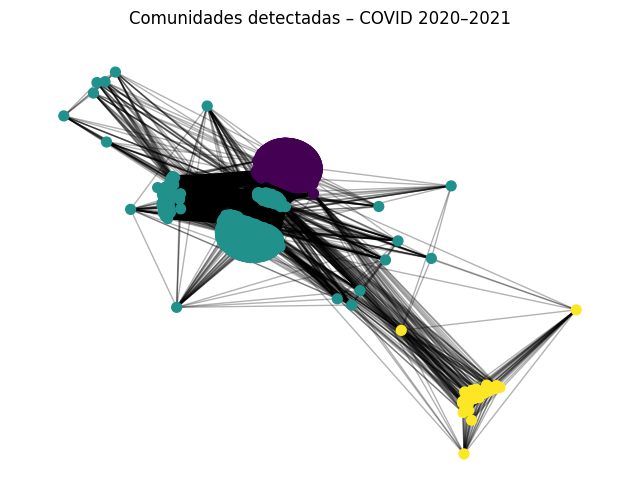

In [ ]:
com_covid, mod_covid = detectar_comunidades(G_covid, "COVID 2020–2021")

Modularidad (Louvain) en Post-COVID 2022–2023: 0.317


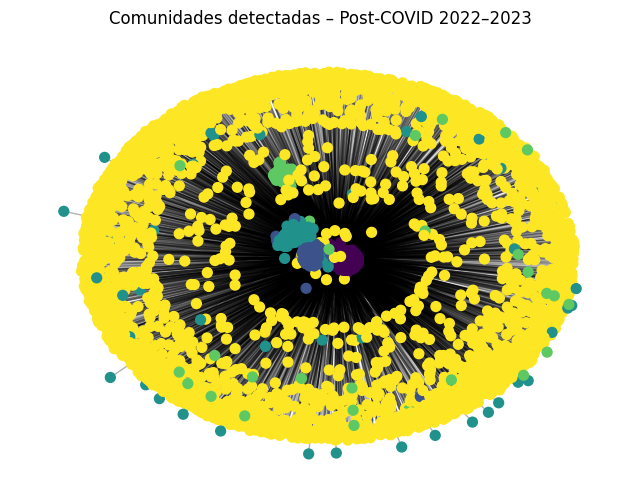

In [ ]:
com_post, mod_post = detectar_comunidades(G_post, "Post-COVID 2022–2023")

# Comparación pre/post evento

Tamaño de red

In [ ]:
nodos_covid = B_covid.number_of_nodes()
nodos_post  = B_post.number_of_nodes()

clientes_covid = len(df_pan['PERSONA'].unique())
clientes_post  = len(df_post['PERSONA'].unique())

servicios_covid = len(df_pan['TIPO_SERVICIO'].unique())
servicios_post  = len(df_post['TIPO_SERVICIO'].unique())

print("---- TAMAÑO DE LA RED ----")
print(f"Clientes COVID: {clientes_covid}")
print(f"Clientes Post-COVID: {clientes_post}")
print(f"Cambio clientes: {clientes_post - clientes_covid}")
print(f"Porcentaje cambio clientes: {((clientes_post - clientes_covid)/clientes_covid)*100:.2f}%\n")

print(f"Servicios COVID: {servicios_covid}")
print(f"Servicios Post-COVID: {servicios_post}")
print(f"Cambio servicios: {servicios_post - servicios_covid}")
print(f"Porcentaje cambio servicios: {((servicios_post - servicios_covid)/servicios_covid)*100:.2f}%")


---- TAMAÑO DE LA RED ----
Clientes COVID: 3248
Clientes Post-COVID: 2272
Cambio clientes: -976
Porcentaje cambio clientes: -30.05%

Servicios COVID: 7
Servicios Post-COVID: 7
Cambio servicios: 0
Porcentaje cambio servicios: 0.00%


Conectividad

In [ ]:
print("\n---- CONECTIVIDAD ----")

print(f"Aristas COVID bipartita: {B_covid.number_of_edges()}")
print(f"Aristas Post-COVID bipartita: {B_post.number_of_edges()}")
print(f"Cambio aristas: {B_post.number_of_edges() - B_covid.number_of_edges()}")

dens_covid = nx.density(B_covid)
dens_post  = nx.density(B_post)

print(f"Densidad COVID: {dens_covid:.4f}")
print(f"Densidad Post-COVID: {dens_post:.4f}")

# Grado promedio por tipo
grados_covid = dict(B_covid.degree())
grado_clientes_covid = sum(grados_covid[c] for c in df_pan['PERSONA'].unique()) / clientes_covid

grados_post = dict(B_post.degree())
grado_clientes_post = sum(grados_post[c] for c in df_post['PERSONA'].unique()) / clientes_post

print(f"Grado promedio clientes COVID: {grado_clientes_covid:.2f}")
print(f"Grado promedio clientes POST-COVID: {grado_clientes_post:.2f}")



---- CONECTIVIDAD ----
Aristas COVID bipartita: 3755
Aristas Post-COVID bipartita: 2887
Cambio aristas: -868
Densidad COVID: 0.0007
Densidad Post-COVID: 0.0011
Grado promedio clientes COVID: 1.16
Grado promedio clientes POST-COVID: 1.27


Modalidades de servicio

In [ ]:
# Conteo de modalidades
mod_covid = df_pan['TIPO_SERVICIO'].value_counts(normalize=True)
mod_post  = df_post['TIPO_SERVICIO'].value_counts(normalize=True)

print("\n---- MODALIDADES (PORCENTAJES) ----")
print("COVID:")
print(mod_covid * 100)

print("\nPOST-COVID:")
print(mod_post * 100)



---- MODALIDADES (PORCENTAJES) ----
COVID:
TIPO_SERVICIO
SERV_2    52.845725
SERV_1    38.750303
SERV_4     5.836764
SERV_5     0.920320
SERV_7     0.726568
SERV_3     0.508598
SERV_6     0.411722
Name: proportion, dtype: float64

POST-COVID:
TIPO_SERVICIO
SERV_1    43.387350
SERV_2    32.906430
SERV_4    11.500261
SERV_5     6.717198
SERV_6     2.665970
SERV_7     2.117094
SERV_3     0.705698
Name: proportion, dtype: float64


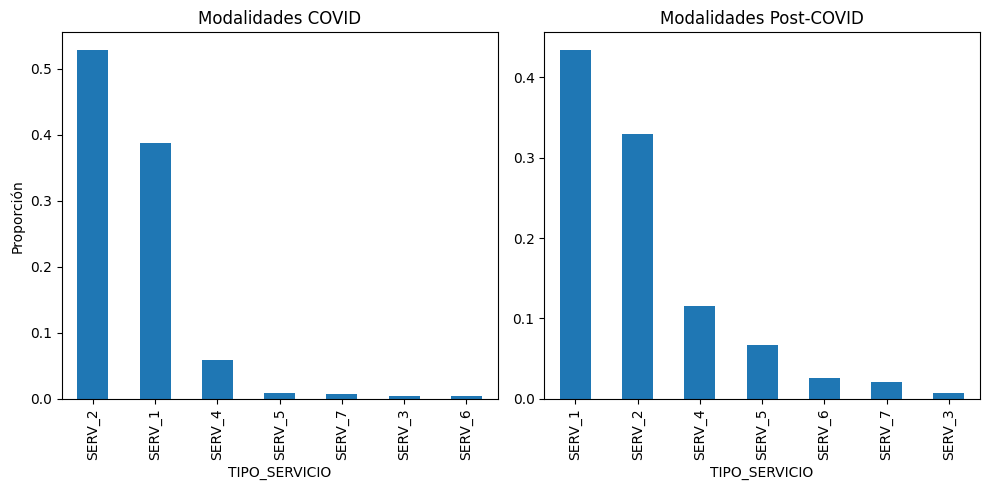

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
mod_covid.plot(kind='bar')
plt.title("Modalidades COVID")
plt.ylabel("Proporción")

plt.subplot(1,2,2)
mod_post.plot(kind='bar')
plt.title("Modalidades Post-COVID")

plt.tight_layout()
plt.show()


# Visualizaciones clave

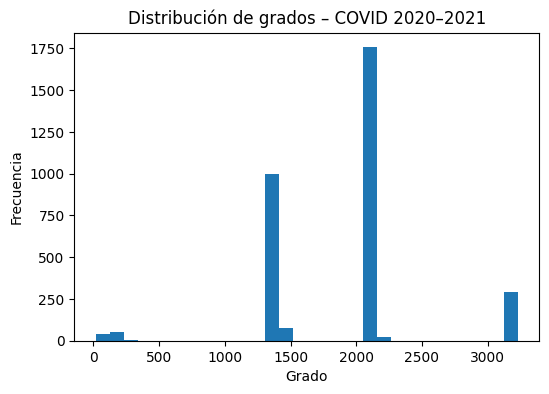

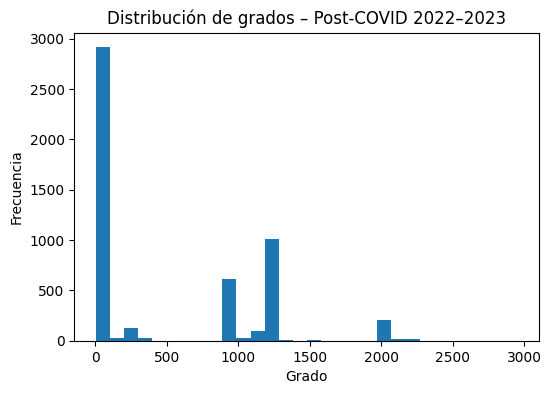

In [ ]:
def histograma_grados(G, titulo):
    grados = [d for n, d in G.degree()]
    plt.figure(figsize=(6,4))
    plt.hist(grados, bins=30)
    plt.title(f"Distribución de grados – {titulo}")
    plt.xlabel("Grado")
    plt.ylabel("Frecuencia")
    plt.show()

histograma_grados(G_covid, "COVID 2020–2021")
histograma_grados(G_post, "Post-COVID 2022–2023")


¿La red se volvió más homogénea?

¿Menos clientes comparten servicios?

¿Hay nodos super conectados (hubs)?